### 0 - Installations and Imports

In [779]:
# !port install graphviz
# # port is brother of brew. 
# # Somehow 'brew install graphviz' is not working seamlessly.
# # So we are using port to install graphviz.

import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import torch
import random


%matplotlib inline


### 1 - Defining a function


Let's define a function f(x) = 3x^2 - 4x + 5

In [780]:
def f(x):
    return 3*x**2 -4*x + 5

In [781]:
f(3.0)


20.0

Lets create an array of x values from -5 to 5 with a step of 0.25. Let's call this array xs.

Also, let's create an array of y values by applying the function f to each x value in xs. Let's call this array ys.

Finally, let's plot the values in xs and ys.

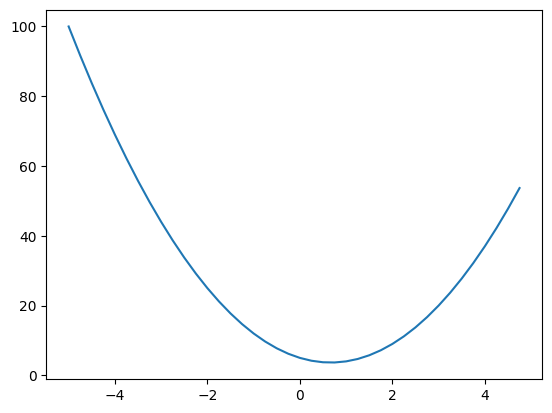

In [782]:
xs = np.arange(-5, 5, 0.25)
gt_ys = f(xs)
plt.plot(xs, gt_ys)
plt.show()

### 2 - Derivative of a function

![Definition of Derivative](assets/definition-of-derivative.png)

Lets find the derivative of f(x) with respect to x at x = 3.0

In [783]:
h = 0.001
x = 3.0
derivative = (f(x + h) - f(x)) / h
print(derivative)

14.00300000000243


In [784]:
# validating it with our knowledge of calculus
def derivative_of_f(x):
    return 6*x - 4
derivative_of_f(3.0)


14.0

So it matches. Also what this 14 means is that if we start with x = 3.0 and increase x by small unit, the value of f(x) will increase by 14 units.

It tells us the impact of x on f(x) at x = 3.0. The derivative is that multiplication factor which tells us the impact of "nudging of x" on f(x) at some x.

#### Lets get more complex

In [785]:
A = 2.0
b = -3.0
c = 10.0

d = A*b + c

print(d)


4.0


We have defined d as a function of multiple variables which are a, b and c.

Now we will measure 
- what is the impact of a small change in a on d.
- what is the impact of a small change in b on d.   
- what is the impact of a small change in c on d.

For sake of brevity, lets do it only for b and c.



In [786]:
h = 0.0001

A = 2.0
b = -3.0
c = 10.0

d1 = A*b + c

b += h

d2 = A*b + c

print((d2 - d1)/h)



2.0000000000042206


You can see that derivative of d with respect to b at (a = 2.0, b = -3.0, c = 10.0) is 2.0.

This means that if we start with b = -3.0 and increase b by small unit (0.0001), the value of d will increase by 2.0 units (i.e 2 * 0.0001).


In [787]:
# Similarly, we can calculate the derivative of d with respect to c at c = 10.0.

h = 0.0001

A = 2.0
b = -3.0
c = 10.0

d1 = A*b + c

c += h

d2 = A*b + c

print((d2 - d1)/h)

0.9999999999976694


You see that derivative of d with respect to c at (a = 2.0, b = -3.0, c = 10.0) is 1.0.

<span style="color: #D67229;">We performed above activity to understand the essence of derivative of a function.</span>



### 3 - Value class

Now lets define the Value class.

In [788]:
class Value:
    def __init__(self, data, _children=(), op='', label=''):
        self.data = data
        self.grad = 0.0 # the derivative of the output with respect to this value. Notice that grad of 0 means that the output is not impacted by change in this value.
        self._prev = set(_children)
        self._op = op
        self.label = label.upper()
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def print_children(self):
        return ' & '.join(str(item.data) for item in self._prev)
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output_node = Value(self.data + other.data, (self, other), '+')

        # backward function of output_node when output_node is the result of 'addition' of child1(i.e. self) and child2(i.e. other)
        def _backward():
            self.grad += 1.0 * output_node.grad  # why += and not =, explanation is in the next cell
            other.grad += 1.0 * output_node.grad
        output_node._backward = _backward

        return output_node

    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output_node = Value(self.data * other.data, (self, other), '*')


        def _backward():
            self.grad += other.data * output_node.grad
            other.grad += self.data * output_node.grad
        output_node._backward = _backward

        return output_node
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        output_node = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * output_node.grad

        output_node._backward = _backward

        return output_node

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output_node = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * output_node.grad
        output_node._backward = _backward

        return output_node

    def exp(self):
        x = self.data
        output_node = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = output_node.data * output_node.grad

        output_node._backward = _backward

        return output_node

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

A = Value(2.0, label='A')
B = Value(-3.0, label='B')
C = Value(10.0, label='C')
E = A*B; E.label = 'E'
D = E + C; D.label = 'D'
F = Value(-2.0, label='F')
L = D * F; L.label = 'L'

# f is a python construct which is used to produce a formatted string. don't confuse it with function f()
print(f'L         : {L}')
print(f'children  : {L.print_children()}')
print(f'operation : {L._op}')

L         : Value(data=-8.0)
children  : 4.0 & -2.0
operation : *


In [789]:
# We have created this Value class
# - to act as a container for simple numbers/floats.
# - whenever two values are added/multiplied, a new value object is generated. We want to keep track of the operation that 
#   generated this new value and the children that were used to generate this new value.

### 4 - Visualizing the lineage of the Value class's object

In [790]:
# Now we need a way to visualize the lineage of the object of this Value class.
# - We will create a function trace() which will take a Value object and return a set of nodes and edges.
# - Nodes are the Value objects and edges are the operations that generated the Value object.

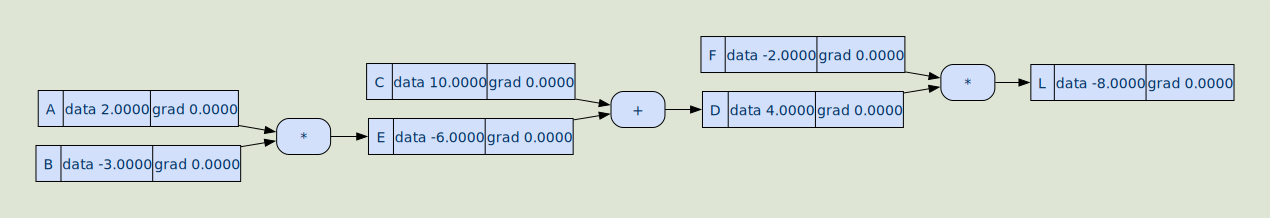

In [791]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir, 'pad': '0.5',  'bgcolor': '#DEE5D4'}, node_attr={'shape': 'Mrecord', 'style': 'filled', 'fillcolor': '#D2E0FB', 'fontcolor': '#003161', 'fontname': 'Roboto'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


draw_dot(L)

### 5 - Understanding partial derivatives i.e. grad

In [792]:
L.grad = 1.0 
# It's kinda obvious and dumb that the ratio of the change in L with respect to change in itself will always be 1.0.


In [793]:
def lol():
    h = 0.0001

    A = Value(2.0, label='A')
    B = Value(-3.0, label='B')
    C = Value(10.0, label='C')
    E = A*B; E.label = 'E'
    D = E + C; D.label = 'D'
    F = Value(-2.0, label='F')
    L1 = D * F; L1.label = 'L1'

    A = Value(2.0 + h, label='A')   # we are nudging a by h
    B = Value(-3.0, label='B')
    C = Value(10.0, label='C')
    E = A*B; E.label = 'E'
    D = E + C; D.label = 'D'
    F = Value(-2.0, label='F')
    L2 = D * F; L2.label = 'L2'

    print('derivative of l with respect to a: ', (L2.data - L1.data)/h)


lol()

derivative of l with respect to a:  6.000000000021544


In [794]:
# This 6 tells us that change in 'l' will be 6 times the change in 'a' when we are making that small change at (a = 2.0, b = -3.0, c = 10.0).


# Now we are going to find derivative of L with respect to all the variables.

# Since l = d * f
# => dl/dd = f and 
# => dl/df = d

# So D.grad will be equal to F.data and F.grad will be equal to D.data.

# Remember, D.grad tells us the impact of change in d on l. Change in l will be that much times the change in d.

# Similarly, F.grad tells us the impact of change in f on l. Change in l will be that much times the change in f.


# Now to find dl/dc, we need to use chain rule. Impact of change in c on l will be the (impact of change in c on d) times the (impact of change in d on l).

# dl/dc = dd/dc * dl/dd

# We already know dl/dd, we just need to find dd/dc.

# Since d = e + c
# => dd/dc = 1.0

# So dl/dc = 1.0 * dl/dd = dl/dd

# Similarly, dl/de = dl/dd


# Now this statement is the crux of back-propagation. 

# When there is a parent node p and it has two child nodes c1 and c2,
# and we already know p.data, c1.data and c2.data,
# and also p.grad,
# then we can find c1.grad and c2.grad using the following formula:

# if(c1.data and c2.data were multiplied to derive p.data)
#     c1.grad = p.grad * c2.data
#     c2.grad = p.grad * c1.data

# else if(c1.data and c2.data were added to derive p.data)
#     c1.grad = p.grad
#     c2.grad = p.grad

# This is the essence of back-propagation. We are able to the calculate grads in previous layer using the grads in the current layer and data in the previous layer.

### 6 - Visualizing the tanh function

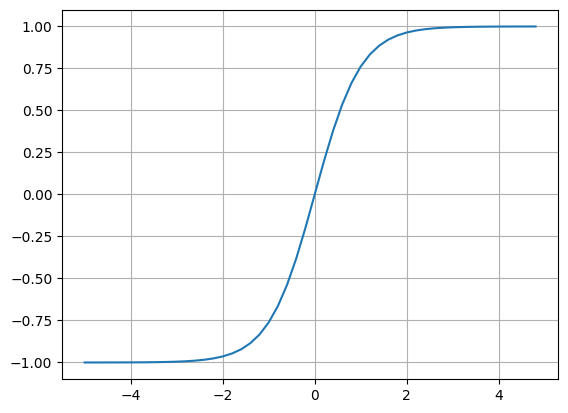

In [795]:
# Lets plot the tanh function to visualize its behavior.
xs = np.arange(-5, 5, 0.2)
gt_ys = np.tanh(xs)
plt.plot(xs, gt_ys); 
plt.grid();

##### Derivative of tanh
![Derivative of tanh](assets/derivative-of-tanh.png)

### 7 - Building a neuron

In [796]:
# Till now, we have been building our understanding about a function and essence of its derivative. We created a nice Value class to ease our handling of nodes which contains data, grads and children. We went through the process of forward propagation where we calculated the final L value using the input variables a,b and c. Also we went through the process of back-propagation where we calculated the grads of L with respect to all the variables.

# But we have been using a random function to calculate L using a, b and c. Now we are going to create a neural network. For that we need to use a function which is not random but a function which is used in practice.

# We will use a function which is used in practice.

# We will first create a simple neuron whose data is going to be calculated using 
# - data in neurons in its previous layer (x1, x2),
# - weights of the edges which connects those two neurons to this neuron (w1, w2),
# - bias attribute of this neuron (b).

# We will then apply the tanh function on the data of this neuron.

# We will then visualize the lineage of this neuron.

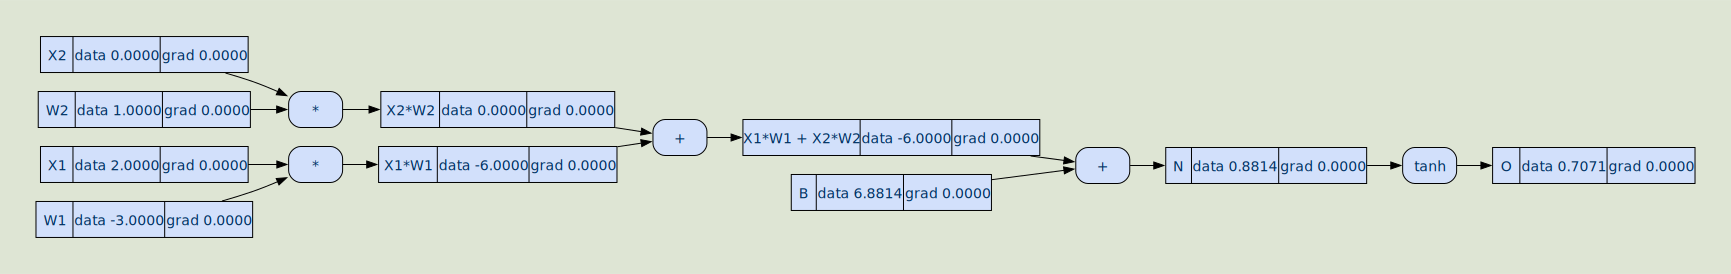

In [797]:
# inputs x1,x2
X1 = Value(2.0, label='X1')
X2 = Value(0.0, label='X2')

# weights w1,w2
W1 = Value(-3.0, label='W1')
W2 = Value(1.0, label='W2')

# bias of the neuron
B = Value(6.8813735870195432, label='B') # bias could have been any other value like 1, 4, 10, 50 etc. We are using this value so that overall number which are going to be output for this bias are sane and are not crazy numbers. I think Andrej has found this number using hit and trial, idk

# x1*w1 + x2*w2 + b
X1W1 = X1*W1; X1W1.label = 'X1*W1'
X2W2 = X2*W2; X2W2.label = 'X2*W2'
X1W1X2W2 = X1W1 + X2W2; X1W1X2W2.label = 'X1*W1 + X2*W2'

N = X1W1X2W2 + B; N.label = 'N'
O = N.tanh(); O.label = 'O'

draw_dot(O)

### 8 - Manual Back-Propagation

We will be doing back-propagation manually now. We will calculate the grads of all the neurons in the network, going backwards.

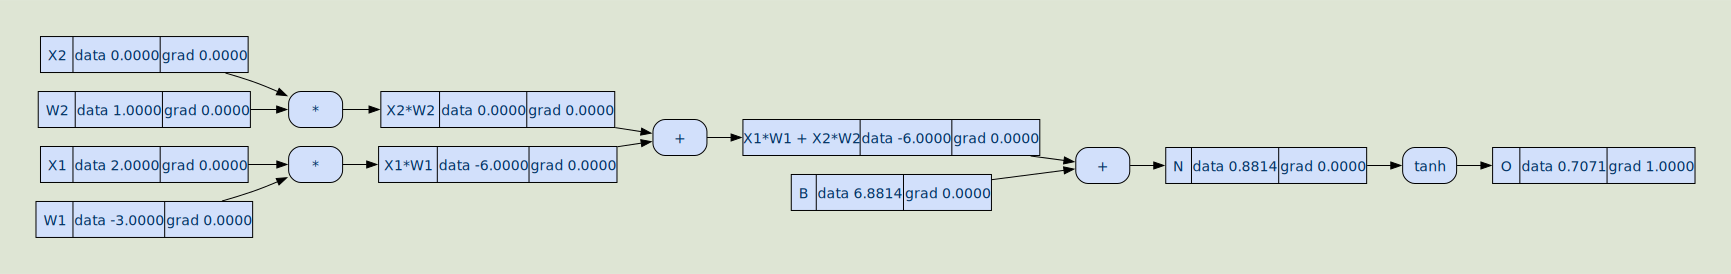

In [798]:
O.grad = 1.0

draw_dot(O)

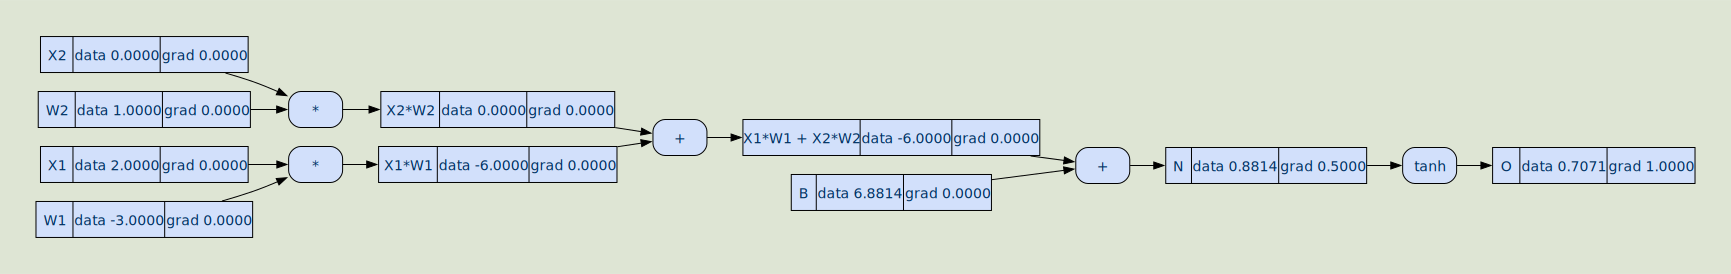

In [799]:
# since o = tanh(n)
# => do/dn = tanh'(n)
# => do/dn = 1 - tanh(n)^2
# => do/dn = 1 - o^2
# => N.grad = 1 - o^2

N.grad = 1 - O.data**2 # this comes out to be 0.5

draw_dot(O)



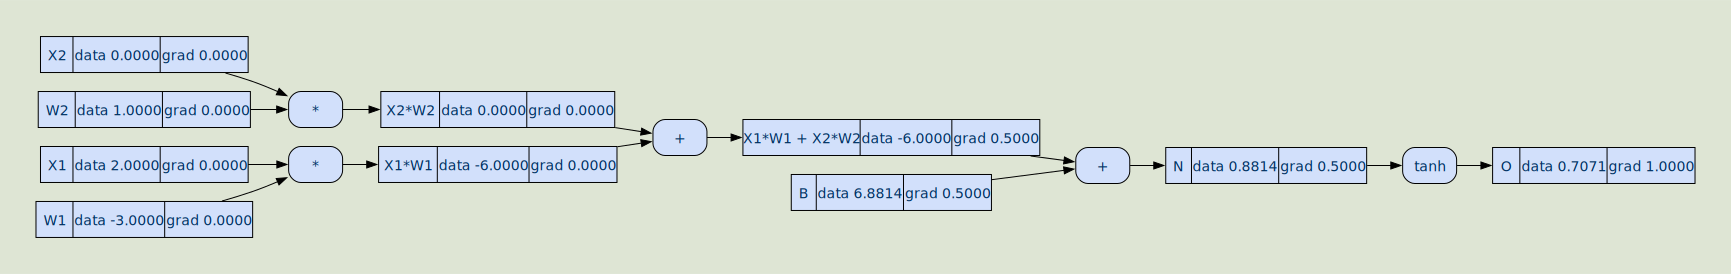

In [800]:
X1W1X2W2.grad = N.grad
B.grad = N.grad

draw_dot(O)

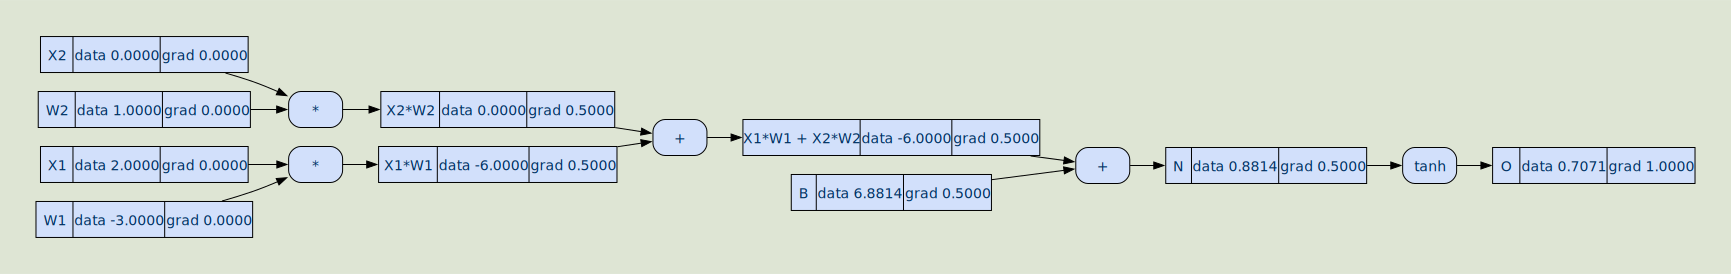

In [801]:
# since + operator was used to derive X1W1X2W2,  the grad of X1W1 and X2W2 will be the same as the grad of X1W1X2W2.
X1W1.grad = X1W1X2W2.grad
X2W2.grad = X1W1X2W2.grad

draw_dot(O)


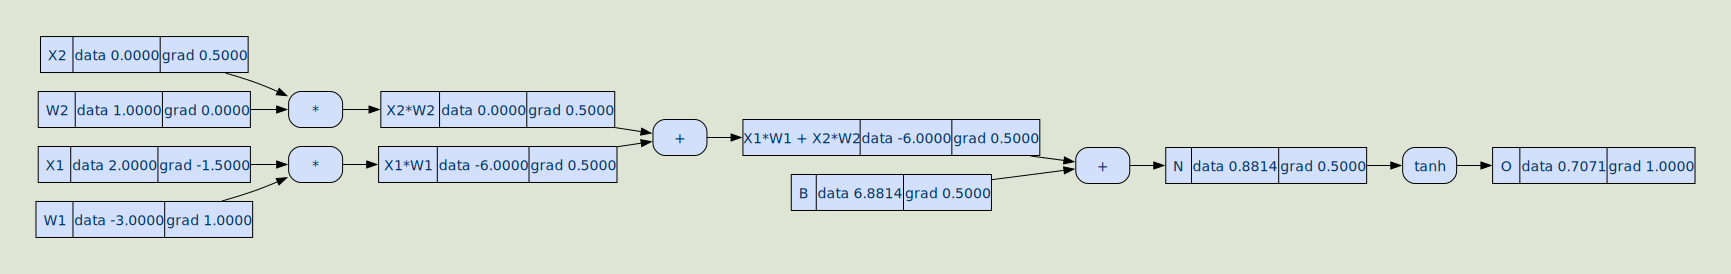

In [802]:

# since * operator was used to derive X1W1, the grad of W1 will be the product of the data of X1 and the grad of X1W1.
W1.grad = X1.data * X1W1.grad
# since * operator was used to derive X1, the grad of X1 will be the product of the data of W1 and the grad of X1W1.
X1.grad = W1.data * X1W1.grad


# since * operator was used to derive X2W2, the grad of W2 will be the product of the data of X2 and the grad of X2W2.
W2.grad = X2.data * X2W2.grad
# since * operator was used to derive X2, the grad of X2 will be the product of the data of W2 and the grad of X2W2.
X2.grad = W2.data * X2W2.grad

draw_dot(O)

### 9 - Automated Back-Propagation

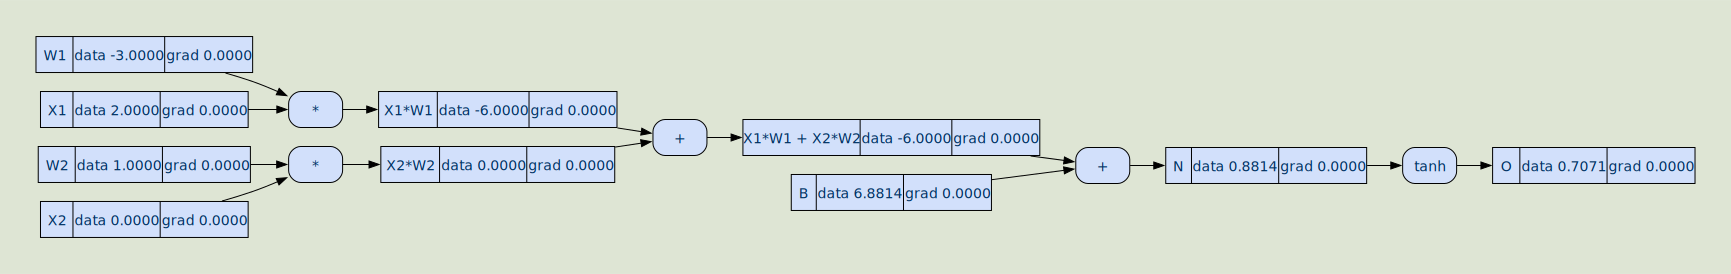

In [803]:
# Lets build the neuron again and do the forward propagation.

# inputs x1,x2
X1 = Value(2.0, label='X1')
X2 = Value(0.0, label='X2')

# weights w1,w2
W1 = Value(-3.0, label='W1')
W2 = Value(1.0, label='W2')

# bias of the neuron
B = Value(6.8813735870195432, label='B') # bias could have been any other value like 1, 4, 10, 50 etc. We are using this value so that overall number which are going to be output for this bias are sane and are not crazy numbers. I think Andrej has found this number using hit and trial, idk

# x1*w1 + x2*w2 + b
X1W1 = X1*W1; X1W1.label = 'X1*W1'
X2W2 = X2*W2; X2W2.label = 'X2*W2'
X1W1X2W2 = X1W1 + X2W2; X1W1X2W2.label = 'X1*W1 + X2*W2'

N = X1W1X2W2 + B; N.label = 'N'
O = N.tanh(); O.label = 'O'

draw_dot(O)

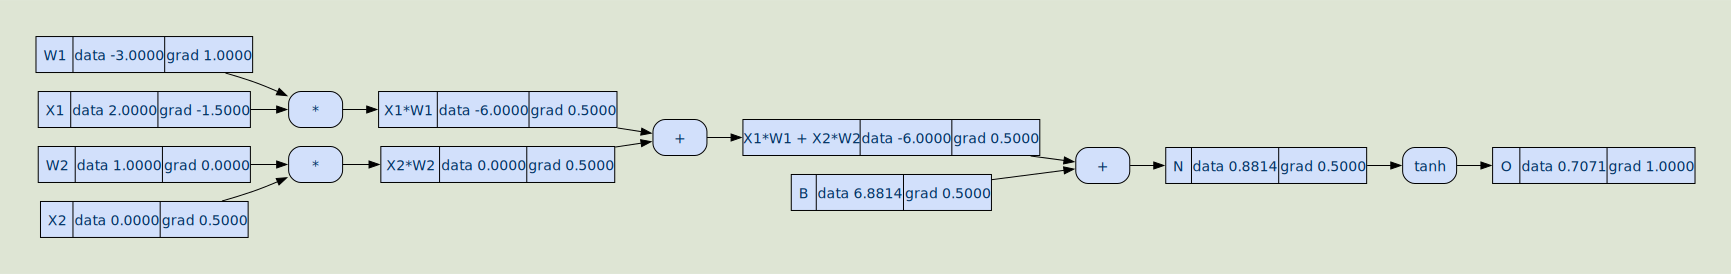

In [804]:
# Now we will do the automated back-propagation.
O.backward()
draw_dot(O)

In [805]:
# Whole of these calculations were for 1 neuron. This neuron in layer l had two neurons in layer l-1 as its children. Those neurons were X1 and X2.

# In above process, we calculated gradients of the final output O with respect to W1, W2 and B.

# We also calculated gradients of the final output O with respect to X1 and X2. These gradients are of no use if X1 and X2 are in the very first layer. But if they lie in some intermediate layer, then we can use these gradients to update the weights of the edges which connect the neurons in the further previous layer (layer l-2) to the neurons in the current layer (layer l-1).

# This is the essence of back-propagation. We are able to calculate the gradients of the neurons in the previous layer using the gradients in the current layer and the data in the previous layer.


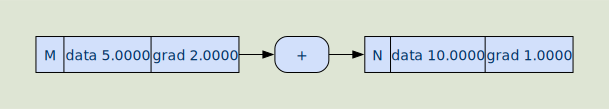

In [806]:
# Note 1:
# Why we should do self.grad += ... and not simply self.grad = ...
# i.e. why use += and not just =
M = Value(5.0, label='M')
N = M + M;     N.label = 'N'

N.backward()
draw_dot(N)

# Ideally M.grad should be 2.0. But if we use only = instead of +=, then M.grad will come out to be only 1.0.
# This is because when we use =, we are overwriting the value of M.grad with 1.0.
# But when we use +=, we are adding 1.0 to the existing value of M.grad.
# So M.grad becomes 1.0 + 1.0 = 2.0.
# This is why we should use += instead of =

# This fact is explained well at this timestamp: https://youtu.be/VMj-3S1tku0?si=XP4SbULPCYFR0n87&t=4948

### 10 - PyTorch

In [807]:
# PyTorch is a modern deep learning library. It is built on top of Torch.

**Scalars**

* A scalar is a single number.


**Vectors**

* **One-dimensional arrays:** Vectors are essentially lists or arrays of numbers arranged in a specific order. 

**Tensors**

* **Generalized arrays:** Tensors are a more general concept that encompass vectors as a special case. 
* **Multidimensional arrays:** They can be thought of as multidimensional arrays of numbers. 
* **Rank:** The "order" or "rank" of a tensor refers to the number of dimensions it has.
    * **Rank-0 tensor:** A scalar (single number)
    * **Rank-1 tensor:** A vector
    * **Rank-2 tensor:** A matrix
    * **Higher-rank tensors:** Arrays with more than two dimensions

**Key Differences**

* **Dimensionality:** Vectors are always one-dimensional, while tensors can have any number of dimensions.
* **Generality:** Tensors are a more general mathematical concept that encompass vectors as a specific type.

**In simpler terms:**

Imagine a vector as a single row or column of numbers. A tensor is like an extension of this, where you can have multiple rows and columns, or even more complex arrangements depending on its rank.

**Applications**

* **Physics:** Tensors are fundamental in physics, describing quantities like stress, strain, and electromagnetic fields.
* **Machine learning:** Tensors are widely used in deep learning for representing data like images, videos, and text.

**In Summary**

Vectors are a specific type of tensor, specifically a rank-1 tensor. Tensors provide a more general framework for representing and manipulating multidimensional data.


In [808]:
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('-')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [809]:
# So we see that PyTorch has same datastructures as we have defined in our Value class with same functionality. Pytorch is more advanced and has more features in addition to the functionality we have defined in our Value class.

### 11 - Building a neural network


In [810]:
#  Lets build a Neuron with random weights and bias configured for it.

class Neuron:
    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

# x stores the data of neurons in the previous layer.
x = [2.0, 3.0]

# we create a neuron which has 2 input edges, and hence 2 weights configured for it.
n = Neuron(2)

# we pass the data of neurons in the previous layer to this neuron.
n(x)

Value(data=-0.7604762233722963)

In [811]:
# Now lets define a layer of neurons.

class Layer:
    def __init__(self, num_inputs, num_outputs):
        # we create num_outputs neurons, each with num_inputs input edges.
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

x = [2.0, 3.0] # previous layer has 2 neurons, hence 2 elements in the list
l = Layer(2, 3) # each neuron in this layer has 2 input edges because previous layer has 2 neurons. This layer has 3 neurons.
l(x)

# Now we have a layer of neurons. We can pass the data of neurons in the previous layer to this layer and get the data of neurons in the current layer.

[Value(data=-0.4074724701036915),
 Value(data=-0.9917565710739898),
 Value(data=-0.9169722941856816)]

In [812]:
# Now lets create a multi-layer perceptron.

class MLP:
    def __init__(self, num_inputs, num_outputs_in_each_layer):
        sz = [num_inputs] + num_outputs_in_each_layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs_in_each_layer))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.parameters()]

x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])

m(x) # output of the multi-layer perceptron when input is x


Value(data=0.5747248104897642)

![Diagram of a multi-layer perceptron](assets/neural-network-diagram.jpeg)

In [813]:
m.parameters()

[Value(data=-0.6793951355547496),
 Value(data=0.31975608514399245),
 Value(data=-0.8680350283431626),
 Value(data=-0.25626962225609273),
 Value(data=-0.7963649451820067),
 Value(data=0.7906482509300863),
 Value(data=0.20219230730700088),
 Value(data=-0.23961507106011393),
 Value(data=0.6740105321196768),
 Value(data=0.5401883501460307),
 Value(data=0.44197510739898327),
 Value(data=0.6679983060310182),
 Value(data=-0.7083037409291795),
 Value(data=0.20447847307003397),
 Value(data=-0.05892556688030681),
 Value(data=0.6378503979341963),
 Value(data=0.4623886276023341),
 Value(data=-0.8398928993380375),
 Value(data=0.8608260997897295),
 Value(data=-0.37621080807617946),
 Value(data=-0.7449464922334135),
 Value(data=0.653104004031934),
 Value(data=-0.36473028810475316),
 Value(data=-0.11548674048238428),
 Value(data=-0.44068284957841475),
 Value(data=0.5014676039064816),
 Value(data=-0.673767973072785),
 Value(data=0.17674960565892128),
 Value(data=-0.4019403331869875),
 Value(data=-0.483

In [814]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

gt_ys = [1.0, -1.0, 1.0, -1.0]  # ground truth ys

pred_ys = [m(x) for x in xs] # predicted ys

pred_ys

loss = sum((pred_y - gt_y)**2 for pred_y, gt_y in zip(pred_ys, gt_ys))

loss

loss.backward()

m.layers[0].neurons[0].w[0].grad


0.23379238633000377

In [815]:
# We just ran the forward propagation on 4 data inputs (i.e. xs) and got 4 predicted outputs (i.e. pred_ys).

# We then calculated the loss between the predicted outputs and the ground truth outputs (i.e. gt_ys).

# We then ran the back-propagation on the loss to calculate the gradients of the parameters of the neural network with respect to the loss.

In [816]:
# Now we will update the parameters of the neural network using the gradients and a learning rate.

# We will repeat the process for multiple iterations to reach to a good enough configuration of the parameters, so that the loss is minimized.

# This is what we call training a neural network.

In [817]:
# You will notice that we will decrease every parameter by a small amount and that amount will be proportional to the gradient of the parameter with respect to the loss.

# What's the logic behind decreasing the parameter by that much proportion only ?

# This is where gradient descent comes into play.

# let X = (x1, x2, x3, ... xn)
# if y = f(X)
# then we first calculate the gradient of y with respect to each of the xi.
# i.e. dy/dx1, dy/dx2, dy/dx3, ... dy/dxn
# this vector of gradients is called the gradient of y with respect to the xi's. lets call this X'

# if we increase x1 by g1, x2 by g2, x3 by g3, ... xn by gn, then there will be change in y.
# There are so many possible ways to increase each of the xi.
# But the claim is that the best way (the one which results maximum increment in y) to increase each of the xi is to increase each of the xi by the gradient of y with respect to the xi.

# To understand its proof, watch these videos:
# - https://youtu.be/tIpKfDc295M?si=SnzgxoPD9jzx_ydV
# - https://youtu.be/_-02ze7tf08?si=4IuFEN3TpEYbgZfM
# - https://youtu.be/TEB2z7ZlRAw?si=uKBCsZ9fHFuJcqHI
# - https://youtu.be/ZTbTYEMvo10?si=EzLFgw_33nopNLXr








In [818]:
# Now we will iterate the process of forward propagation, back-propagation and parameter update for 2000 iterations.

loss_tracker = []

for k in range(2000):
  # forward pass
  # it updates the data in all the neurons in the neural network.
  pred_ys = [m(x) for x in xs]
  loss = sum((pred_y - gt_y)**2 for pred_y, gt_y in zip(pred_ys, gt_ys))
  
  # backward pass
  # it updates the gradients of all the parameters in the neural network.
  for p in m.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  # it updates the data in all the parameters in the neural network.
  for p in m.parameters():
    p.data += -0.001 * p.grad
  
  print(k, loss.data)

  loss_tracker.append(loss.data)




0 8.119360550901625
1 8.06698537759363
2 8.014011345831468
3 7.9604484171372984
4 7.906307900827243
5 7.851602507138738
6 7.796346396256121
7 7.740555222360157
8 7.684246171801718
9 7.627437994485426
10 7.570151027546889
11 7.51240721041836
12 7.454230090403534
13 7.395644817923273
14 7.336678130651608
15 7.277358325835657
16 7.21771522018477
17 7.157780096823575
18 7.097585638930427
19 7.037165849826961
20 6.9765559594451965
21 6.915792317274969
22 6.854912272084435
23 6.793954038908138
24 6.7329565540074485
25 6.671959318723667
26 6.611002233360313
27 6.550125422443296
28 6.489369052910135
29 6.428773146966133
30 6.368377391510569
31 6.308220946172806
32 6.248342252101423
33 6.188778843713404
34 6.129567165630964
35 6.070742397007505
36 6.012338285370186
37 5.954386991984294
38 5.896918950576367
39 5.839962741042219
40 5.783544979517897
41 5.727690225913378
42 5.672420909707945
43 5.617757274491951
44 5.563717341420985
45 5.5103168914347584
46 5.457569465792843
47 5.405486384201067
4

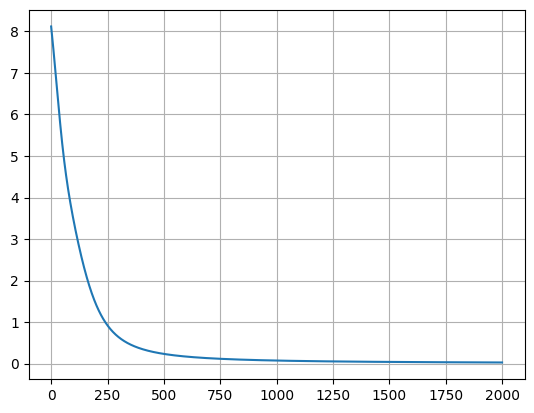

In [819]:
plt.plot(loss_tracker)
plt.grid()
plt.show()


In [821]:
print(gt_ys)
print([pred_y.data for pred_y in pred_ys])

[1.0, -1.0, 1.0, -1.0]
[0.9224822889614271, -0.9499497290834782, 0.9109059897915798, -0.8949092741020179]


In [ ]:
# You can see that the predicted outputs are very close to the ground truth outputs.

In [827]:
# This is the final setting of the parameters of the neural network.
print('number of parameters: ', len(m.parameters()))
print('parameters: ', [p.data for p in m.parameters()])


number of parameters:  41
parameters:  [-0.6824878922326637, 0.5917842372813755, -0.31334937646442995, -0.2180333895548304, -0.7858281624447925, 0.999982888137803, 0.5709621115835167, -0.2343493371696739, 0.6857795246193236, 0.5547324071934522, 0.42761887137167803, 0.6813151831681034, -0.5913988687014011, -0.17397602641370308, -0.6762439150020575, 0.6427998060017364, 0.4487330025326704, -0.7909124672864735, 0.8339481111368735, -0.3130432603428686, -0.7754635369998468, 0.6366424280631424, 0.367348937585476, -0.1908116864449027, -0.43171157885674083, 0.39218091677505196, -0.7056940889183281, -0.14408246468783975, -0.43480719751787456, -0.5751355462519147, -0.6606900055420594, 0.12449727489406842, 1.2016331111694454, -0.22426872883326346, -0.8531944531399626, 0.2566011359161444, -0.27724417449107785, 0.7904674824452503, -0.4625654145110765, 1.457788272234813, -0.5090805261179904]
